# Dynamic Time Warping

## Paul Anzel, 5-26-17

Quite often we want to compare the qualitative shapes of time series. For example, you're trying to do speech processing, and you care about the general words being said and not the exact rhythm to the second. Dynamic Time Warping lets you compare two time series where your "time" factor needs to squash or stretch.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

sns.set_style("white")
%matplotlib inline

## The basic problem

For two time series

$$ Q = q_1,q_2,q_3,\cdots,q_i,\cdots,q_n $$
$$ C = c_1,c_2,c_3,\cdots,q_j,\cdots,c_m $$

We could construct a matrix D of distances

$$ D_{ij} = \text{dist}(q_i, c_j) = (q_i - c_j)^2$$

Then we could construct warping path

$$ W = w_1,w_2,w_3,\cdots,w_k,\cdots,w_K $$

of entries in the matrix.

The following restrictions are made on $W$
- $W$ goes from corner to corner of the matrix $D$ (viz, $w_1 = (1,1)$, $w_K = (n,m)$).
- Our path can only move horizontally, vertically, or diagonally, and must make single steps.
- The motion must always be monotonically moving towards the destination.

The last two restrictions basically mean that if we're at step $w_k = (i,j)$, then the only valid candidates for $w_{k+1}$ are $(i+1, j)$, $(i,j+1)$, and $(i+1,j+1)$.

The best warping path is the one that minimizes the warping cost

$$ DTW(Q,C) = \min \frac{\sqrt{\sum_{w \in W}D_w}}{K}$$

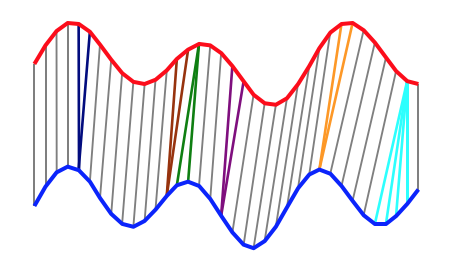

In [2]:
Image(filename='two_signals.png')
# Image below from http://www.cs.ucr.edu/~eamonn/DTW_myths.ppt

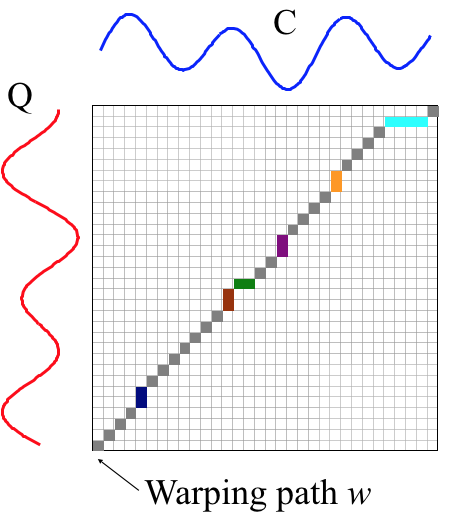

In [3]:
Image(filename='warping_path.png')
# Image below from http://www.cs.ucr.edu/~eamonn/DTW_myths.ppt

This doesn't give us an easy way to find the warping path $W$ (since there's exponentially many valid paths still) but we can build up the list of distances iteratively, creating a new matrix of values $\gamma$.

First, start at $(1,1)$ (the known starting point for $W$), and set $\gamma_{1,1} = D_{1,1}$. Then, building up increasing $i$ and $j$, find the values
$$\gamma_{i,j} = D_{i,j} + \min \left( \gamma_{i-1,j}, \gamma_{i,j-1}, \gamma_{i-1,j-1} \right) $$

and just build up to the corner at $(n,m)$. (If you actually want to keep track of the actual path, you'll want to keep track at each matrix point which direction we went to find the min value.

In [4]:
# Making a couple of signals, offset by t = 2 and one of them is a bit weird

t_1 = np.linspace(0, 10, 100)
series1 = np.sin(np.pi*t_1)
t_2 = np.linspace(2, 12, 100)
series2 = np.power(np.sin(np.pi*t_2), 3) + 2

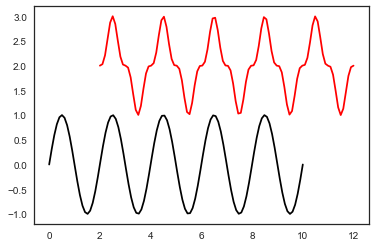

In [5]:
plt.plot(t_1, series1, color='k')
plt.plot(t_2, series2, color='r')

In [6]:
# This could be optimized with some vectorizing, but that's for later...
def make_D_matrix(Q, C):
    n = len(Q)
    m = len(C)
    D = np.zeros((n, m))
    for ii in range(n):
        for jj in range(m):
            D[ii, jj] = (Q[ii] - C[jj])**2
    return D

Along with the distance values, it's common to have your path matrix be a bunch of pointers/references to other entries in the path matrix, letting you sketch out a path from the end back to home.

In [7]:
def make_gamma_and_dir_mtx(D):
    n, m = D.shape
    gamma = np.zeros((n, m))
    dir_mtx = np.empty((n, m), dtype='object')
    
    gamma[0,0] = D[0,0]
    dir_mtx[0,0] = 'S'
    # kk = ii + jj
    for kk in range(1, n+m):
        for ii in range(kk+1):
            jj = kk - ii
            # Out of bound cases
            if ii >= n:
                continue
            if jj >= m:
                continue
  
            if ii == 0:  # Edge of matrix
                gamma[ii, jj] = D[ii, jj] + gamma[ii, jj - 1]
                dir_mtx[ii, jj] = (ii, jj - 1)
            elif jj == 0:  # Same
                gamma[ii, jj] = D[ii, jj] + gamma[ii - 1, jj]
                dir_mtx[ii, jj] = (ii - 1, jj)
            else:  # Regular
                gamma1 = gamma[ii, jj - 1]
                gamma2 = gamma[ii - 1, jj]
                gamma3 = gamma[ii - 1, jj - 1]
                if (gamma1 < gamma2) and (gamma1 < gamma3):
                    dir_mtx[ii, jj] = D[ii, jj] + gamma1
                    dir_mtx[ii, jj] = (ii, jj - 1)
                elif (gamma2 < gamma1) and (gamma2 < gamma3):
                    dir_mtx[ii, jj] = D[ii, jj] + gamma2
                    dir_mtx[ii, jj] = (ii - 1, jj)
                else:
                    dir_mtx[ii, jj] = D[ii, jj] + gamma3
                    dir_mtx[ii, jj] = (ii - 1, jj - 1)
    
    return gamma, dir_mtx

In [8]:
D = make_D_matrix(series1, series2)
gamma, dir_val = make_gamma_and_dir_mtx(D)

In [9]:
D[:5, :5]

array([[ 4.        ,  4.1224474 ,  4.87716634,  6.45413428,  8.24101281],
       [ 2.84923109,  2.95271865,  3.59632271,  4.96605795,  6.5468586 ],
       [ 1.9799081 ,  2.06632911,  2.60991396,  3.7931103 ,  5.18841156],
       [ 1.40523017,  1.47818215,  1.94283118,  2.97880976,  4.22771366],
       [ 1.09222932,  1.15665477,  1.5713337 ,  2.51411653,  3.670344  ]])

In [10]:
dir_val[95:, 95:]

array([[(94, 94), (94, 95), (94, 96), (94, 97), (94, 98)],
       [(95, 94), (95, 95), (95, 96), (95, 97), (95, 98)],
       [(96, 94), (96, 95), (96, 96), (96, 97), (96, 98)],
       [(97, 94), (97, 95), (97, 96), (97, 97), (97, 98)],
       [(98, 94), (98, 95), (98, 96), (98, 97), (98, 98)]], dtype=object)

In [11]:
def get_path_from_dir_mtx(dir_mtx):
    # We start at the end, follow it back to the beginning, and then flip the list
    n, m = dir_mtx.shape
    path = [(n-1, m-1)]
    if (n == 1) and (m == 1):
        print "Single entry matrix provided, There's not really any path to compare"
        return path
    for test_ind in range(n+m):
        ii, jj = path[-1]
        next_entry = dir_mtx[ii, jj]
        if next_entry == 'S':
            return list(reversed(path))
        path.append(next_entry)
    else:
        raise ValueError("dir_mtx does not give a monotonic path!")

In [12]:
path = get_path_from_dir_mtx(dir_val)

In [13]:
path

[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 5),
 (6, 6),
 (7, 7),
 (8, 8),
 (9, 9),
 (10, 10),
 (11, 11),
 (12, 12),
 (13, 13),
 (14, 14),
 (15, 15),
 (16, 16),
 (17, 17),
 (18, 18),
 (19, 19),
 (20, 20),
 (21, 21),
 (22, 22),
 (23, 23),
 (24, 24),
 (25, 25),
 (26, 26),
 (27, 27),
 (28, 28),
 (29, 29),
 (30, 30),
 (31, 31),
 (32, 32),
 (33, 33),
 (34, 34),
 (35, 35),
 (36, 36),
 (37, 37),
 (38, 38),
 (39, 39),
 (40, 40),
 (41, 41),
 (42, 42),
 (43, 43),
 (44, 44),
 (45, 45),
 (46, 46),
 (47, 47),
 (48, 48),
 (49, 49),
 (50, 50),
 (51, 51),
 (52, 52),
 (53, 53),
 (54, 54),
 (55, 55),
 (56, 56),
 (57, 57),
 (58, 58),
 (59, 59),
 (60, 60),
 (61, 61),
 (62, 62),
 (63, 63),
 (64, 64),
 (65, 65),
 (66, 66),
 (67, 67),
 (68, 68),
 (69, 69),
 (70, 70),
 (71, 71),
 (72, 72),
 (73, 73),
 (74, 74),
 (75, 75),
 (76, 76),
 (77, 77),
 (78, 78),
 (79, 79),
 (80, 80),
 (81, 81),
 (82, 82),
 (83, 83),
 (84, 84),
 (85, 85),
 (86, 86),
 (87, 87),
 (88, 88),
 (89, 89),
 (90, 90),
 (91, 91),
 (92, 92

# Improvements to the standard DTW algorithm

The standard DTW technique, while simple, requires a lot of computation ($O(nm)$ - the time complexity is quadratic) and can often make mistakes in figuring out which features in one time series should correspond to features in a second series.

## Derivative Dynamic Time Warping

Reference: http://www.cs.ucr.edu/~eamonn/sdm01.pdf

Instead of having your $D$ matrix be based on distances $(q_i - c_j)^2$, have the $D$ matrix be based on the distance of the derivatives, $(D_x q_i - D_x c_j)^2$, instead.

In the implementation done by Keogh, et al. above, they approximated the derivative by averaging the backwards distance and centered difference after some exponential smoothing.

$$ D_x q_i = \frac{(q_i - q_{i-1}) + (q_{i+1} - q_{i-1})/2}{2}$$

With that said, pretty much any derivative finding method (e.g. Savitsky-Golay derivative filters) should work. Just be careful about how you deal with the ends of the series.

Keogh found that this technique does a good job at preventing data-sets from having singularities (where a large fraction of one series would warp to a single point on another series), which often happens with standard DTW.

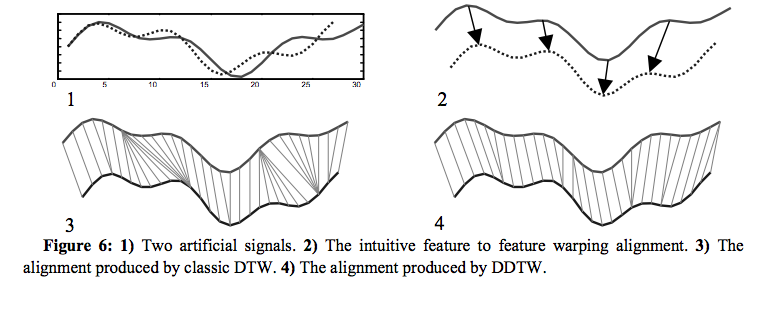

In [14]:
Image(filename='ddtw_1.png')
# Image below from http://www.cs.ucr.edu/~eamonn/sdm01.pdf

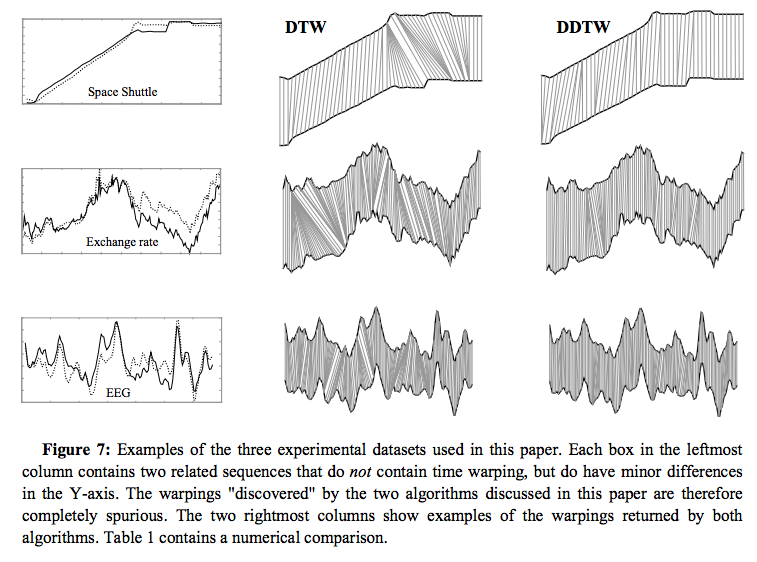

In [15]:
Image(filename='ddtw_2.png')
# Image below from http://www.cs.ucr.edu/~eamonn/sdm01.pdf

## Banding

An old technique, but useful. Instead of considering the entirity of the $D$ matrix as traverseable, we only look at (and calculate) a narrow band of elements in the middle:

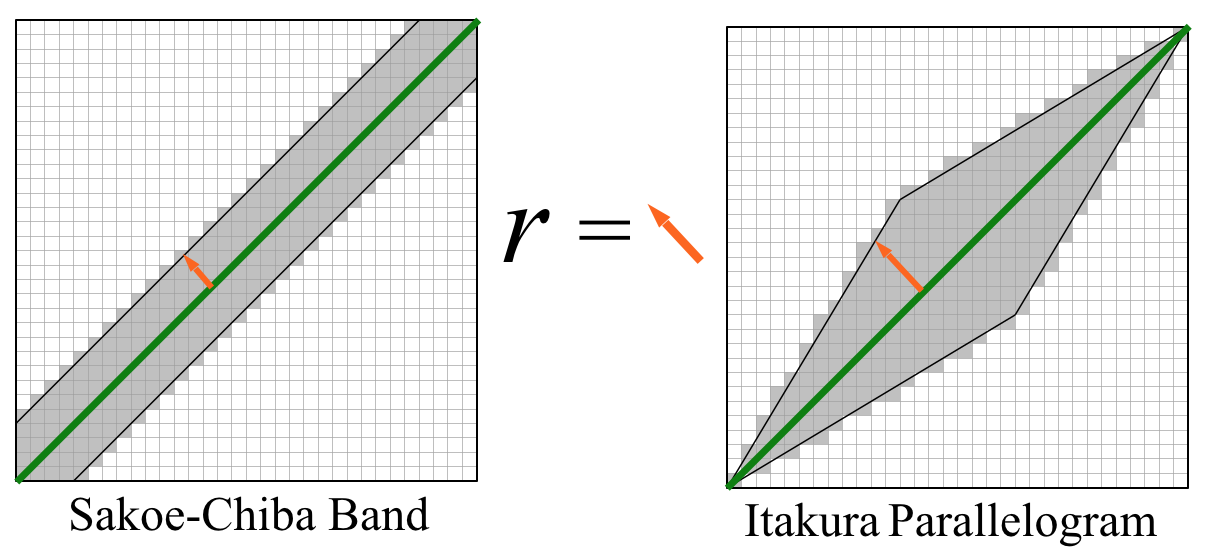

In [16]:
Image(filename='two_bands.png')
# Image from http://www.cs.ucr.edu/~eamonn/vldb_keogh_2002.ppt

This can dramatically reduce the amount of computation needed (often by 2 orders of magnitude, depending on how the __radius__ $r$ is chosen). On the other hand, setting $r$ to be too restrictive can cause the DTW algorithm to miss what should be clear feature matches--if the second series has features that are just too far apart in time, the band won't allow them to be matched.

You can also create bands based on local steps that can be taken in generating the path, as in the figure below:

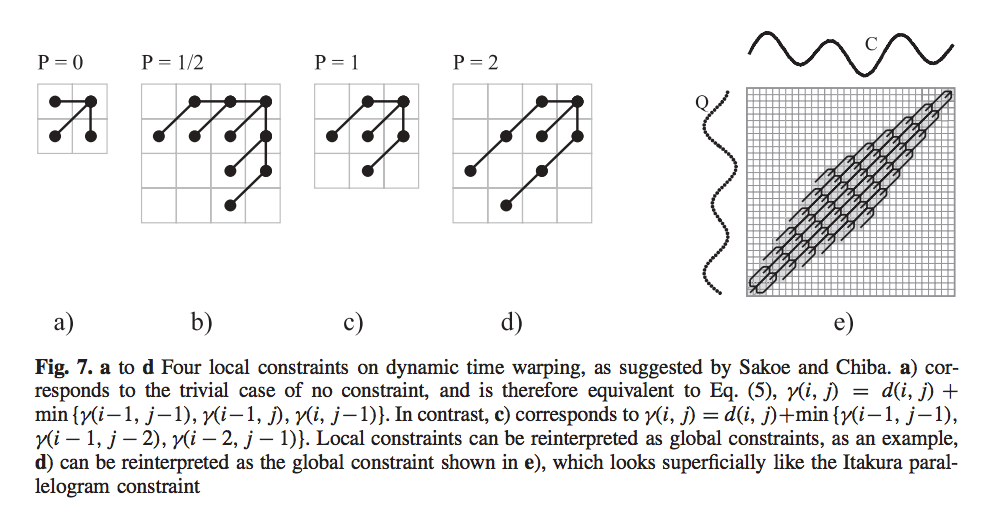

In [17]:
Image(filename="local_path.png")
# Image from http://www.cs.ucr.edu/~eamonn/KAIS_2004_warping.pdf

Many of the approaches below involve some form of banding. A common first guess for radius values is around 10% of the time-series length.

## Piecewise Aggregate Approximation

http://www.cs.ucr.edu/~eamonn/kais_2000.pdf

http://www.cs.ucr.edu/~eamonn/pakdd200_keogh.pdf


Instead of having length $n$ time series, we sub-sample the time series into $N$ ($N < n$) segments, averaging the time series over each segment. So, if $N = n/10$, for example, $y_1 = \text{mean} (x_1, \cdots, x_{10})$, $y_2 = \text{mean} (x_{11}, \cdots, x_{20})$, and so forth. This averaging takes $O(n)$ time for the time series, and then we have a $O(N^2)$ time for DTW instead of $O(n^2)$. This was found to create significant savings in time while still maintaining a strong degree of accuracy when trying to match a given series to various candidates.

## FastDTW

http://cs.fit.edu/~pkc/papers/tdm04.pdf

The FastDTW algorithm has some similarities to the Piecewise Aggregate Approximation approach. Highly subsample (or average) each of of the time series, and figure out the path based on that. Then go to a finer sample, and look at paths only within a radius of the sub-sampled path.

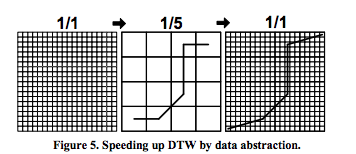

In [18]:
Image(filename="fastdtw.png")
# Image from paper linked above

## Segmented Dynamic Time Warping

http://www.cs.ucr.edu/~eamonn/pkdd99keogh_pazzani.pdf

Another way to compress the time series is to break them into piece-wise linear signals, which requires far fewer data points to represent the time series.

## Lower bound approximations

Quite often, the issue we're dealing with is not calculating one DTW distance, but instead doing multiple calculations. For example, if we've got 20 candidate time-series structures and we want to see which of them a particular time series is closest too.

Lower-bound approximations basically try and use a relatively fast operation ($O(n)$) to get some lower-bound for the DTW distance. If you've done at least one full DTW calculation for one time series and then find a lower bound for another above the full DTW values for the first series, you can safetly pass on the second sequence.

In [19]:
def lower_bound_sequential_scan(test_series, series_list, lower_bound_function, DTW_kw):
    # test_series is a candidate series, with length n
    # series_list is a bunch of comparison candidates, also length n
    # lower_bound_function is a function to find a lower-bound of DTW for
    # the series
    # DTW_kw are keywords for the dynamic time warping approach
    best_so_far = np.inf
    index_of_best_match = 0
    for idx, series in enumerate(series_list):
        LB_dist = lower_bound_function(test_series, series)
        if LB_dist < best_so_far:
            true_dist = DTW(test_series, series)
            if true_dist < best_so_far:
                best_so_far = true_dist
                index_of_best_match = idx
    return index_of_best_match, best_so_far

There are a number of different ways to calculate the lower bound, though Keogh found one (http://www.cs.ucr.edu/~eamonn/KAIS_2004_warping.pdf) that was, in practice, able to reduce compute time by three orders of magnitude for various data sets.

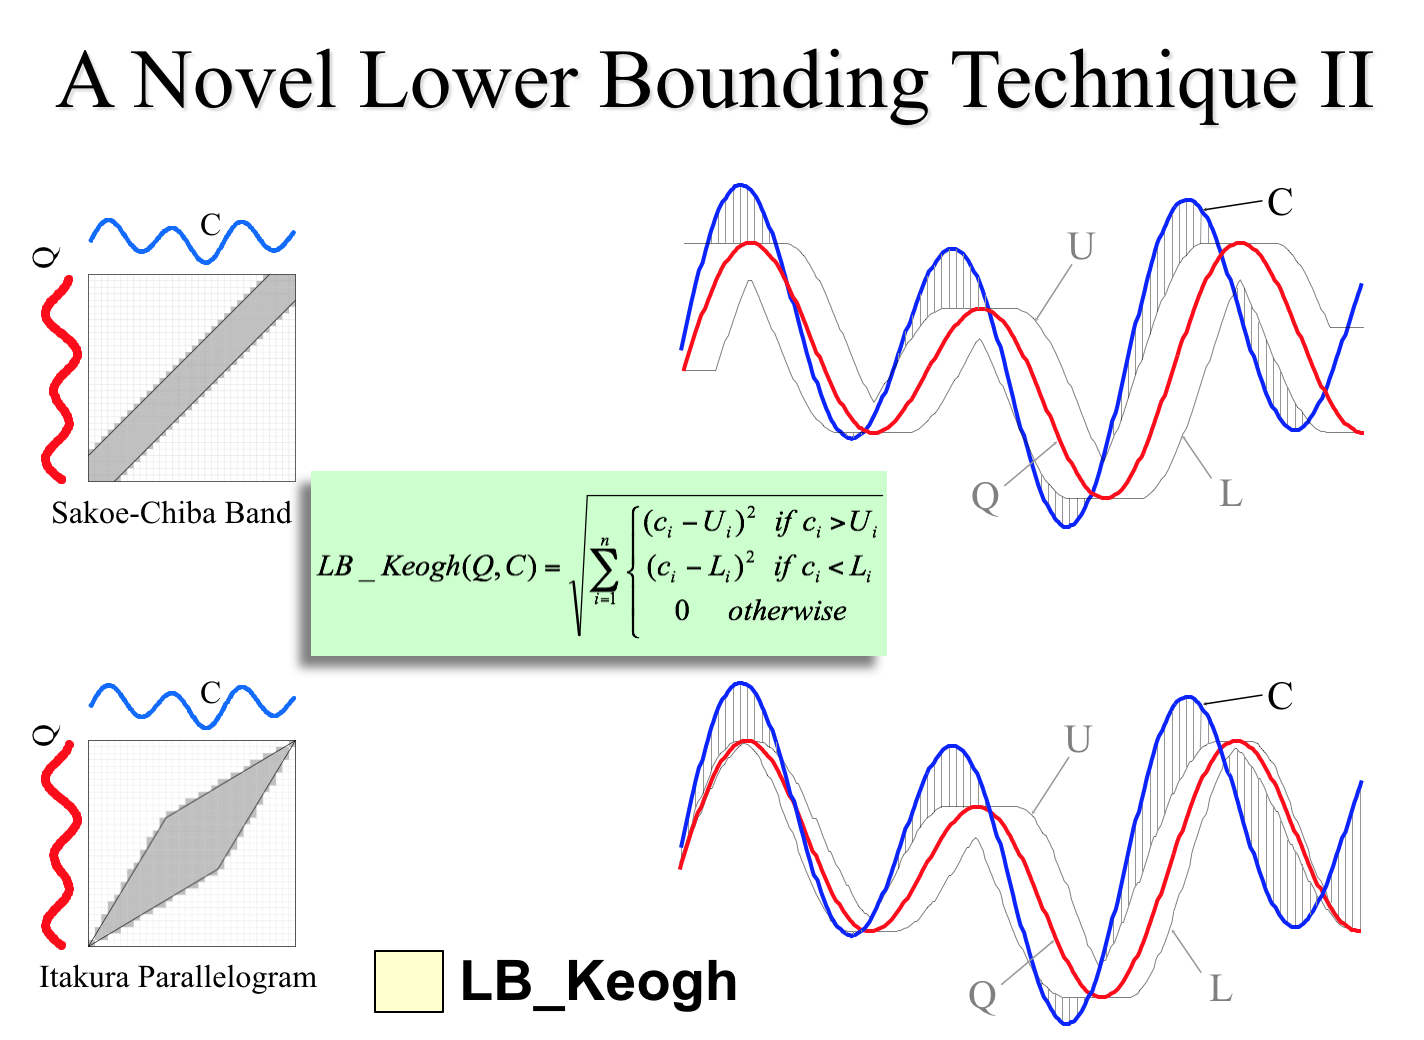

In [20]:
Image(filename="lb_keogh.png")
# http://www.cs.ucr.edu/~eamonn/vldb_keogh_2002.ppt - slide by Eamonn Keogh

## Some final notes

- While DTW works on unequally-spaced time series, Keogh et al [showed](http://www.cs.ucr.edu/~eamonn/DTW_myths.pdf) that there is no real loss in accuracy if one time series is resampled to be the length of the second, which is necessary for a lot of the lower-bounding techiques.